# Student Performance dataset
---
#### Name: 劉耀文 (Yao-Wen Liu)
#### Student ID: 0716236
---

## 1. Data Input
### Import libraries and read dataset from file
* Use read_csv() in Pandas to read the dataset from file.

In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.decomposition import PCA
from sklearn.model_selection import KFold, train_test_split
from sklearn.tree import DecisionTreeClassifier, export_graphviz
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, recall_score
from sklearn.metrics import precision_score as ps
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
from random import choice # for random select sample from test data split in section 8
import pydotplus # for visualize decision tree
%matplotlib inline

dataset = pd.read_csv("student-mat.csv", sep=";")
categorical_index = ['school', 'sex', 'address', 'famsize', 'Pstatus', 'Mjob', 'Fjob', 'reason', 'guardian', 'schoolsup', 'famsup', 'paid', 
                     'activities', 'nursery', 'higher', 'internet', 'romantic']
numerical_index = ['age', 'Medu', 'Fedu', 'traveltime', 'studytime', 'failures', 'famrel', 'freetime', 'goout', 'Dalc', 'Walc', 'health', 'absences', 'G1', 'G2']
dataset

,school,sex,age,address,famsize,Pstatus,Medu,Fedu,Mjob,Fjob,...,famrel,freetime,goout,Dalc,Walc,health,absences,G1,G2,G3
0,GP,F,18,U,GT3,A,4,4,at_home,teacher,...,4,3,4,1,1,3,6,5,6,6
1,GP,F,17,U,GT3,T,1,1,at_home,other,...,5,3,3,1,1,3,4,5,5,6
2,GP,F,15,U,LE3,T,1,1,at_home,other,...,4,3,2,2,3,3,10,7,8,10
3,GP,F,15,U,GT3,T,4,2,health,services,...,3,2,2,1,1,5,2,15,14,15
4,GP,F,16,U,GT3,T,3,3,other,other,...,4,3,2,1,2,5,4,6,10,10
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
390,MS,M,20,U,LE3,A,2,2,services,services,...,5,5,4,4,5,4,11,9,9,9
391,MS,M,17,U,LE3,T,3,1,services,services,...,2,4,5,3,4,2,3,14,16,16
392,MS,M,21,R,GT3,T,1,1,other,other,...,5,5,3,3,3,3,3,10,8,7
393,MS,M,18,R,LE3,T,3,2,services,other,...,4,4,1,3,4,5,0,11,12,10


## 2. Data preprocessing
* Use ColumnTransformer() and OneHotEncoder() in scikit-learn to do one-hot encode to categorical features.
* Use Dataframe.sample(frac=1) in Pandas to shuffle the data.

In [2]:
# do one-hot encode to categorical features
ct = ColumnTransformer([("One-Hot-Encode", OneHotEncoder(), categorical_index)], remainder = 'passthrough')
encoded = ct.fit_transform(dataset)
encoded = pd.DataFrame(encoded)

'''
# normalize numerical data
encoded[list(range(43,58))]
for columns in range(43,58):
    encoded[columns] = (encoded[columns] - encoded[columns].min()) / (encoded[columns].max() - encoded[columns].min())
'''
# Shuffle the data.
processed_data = encoded.sample(frac=1).reset_index(drop=True)

X = processed_data.drop([58], axis=1).values
Y = processed_data[58].values

# Transform label format so we can do the required two tasks described below Data section.
binary_Y = []
five_Y = []

for row in Y:
    if row >= 16:
        binary_Y.append(1.0)
        five_Y.append(4.0)
    elif row >=14:
        binary_Y.append(1.0)
        five_Y.append(3.0)
    elif row >=12:
        binary_Y.append(1.0)
        five_Y.append(2.0)
    elif row >=10:
        binary_Y.append(1.0)
        five_Y.append(1.0)
    else:
        binary_Y.append(0.0)
        five_Y.append(0.0)


## 3. Principal components analysis (PCA)
* Use PCA() in scikit-learn to perform PCA on the processed data.
* 把這部分拉到每個fold裡面去做，因為spec以及DC上助教都有說要先用training split去fit，再transform到training, validation split。
    * 故以下code就直接註解，但一開始我是先做PCA再去切資料的。

In [3]:
'''
pca = PCA(n_components='mle')
pca.fit(X)
X_pca = pca.transform(X)
print(f'Shape without PCA: {X.shape}')
print(f'Shape with PCA: {X_pca.shape}')
'''

"\npca = PCA(n_components='mle')\npca.fit(X)\nX_pca = pca.transform(X)\nprint(f'Shape without PCA: {X.shape}')\nprint(f'Shape with PCA: {X_pca.shape}')\n"

## 4. Model Construction

#### Something used by 3 kind of model
* Use KFold() to get the k-fold validation index of each epoch.
* Declare some list to store the performance score of each model.

In [4]:
# get index of each epoch
k_fold = KFold(n_splits=3)
k_fold.get_n_splits(X)

# declare score and matrics list
'''
list: decision tree 0-3
      random forest 4-11
      K-NN 12-19

matrix:
    binary: decision tree 0-1
            random forest 2-5
            K-NN 6-9

    five: decision tree 0-1
          random forest 2-5
          K-NN 6-9
'''
accuracy_list = [0] * 20
binary_recall_list = [0] * 10
five_recall_list = [[0]*5] * 10
binary_precision_list = [0] * 10
five_precision_list = [[0]*5] * 10
binary_matrics = [[[0]*2]*2]*10
five_matrics = [[[0]*5]*5]*10

#### Decision Tree
* Use DecisionTreeClassifier() in scikit-learn to build decision tree models.
    * Use criterion="entropy" to select ID3 as our implementation method.
* User confusion_matrix(), accuracy_score(), recall_score() and precision_score() to evaluate the performance of the model.
    * Call precision_score() directly might cause some problem, so I use ps() to call it when I import the library.

In [5]:
######## build 4 different trees ########
# trees for binary target
bw_tree = DecisionTreeClassifier(criterion="entropy")
bwo_tree = DecisionTreeClassifier(criterion="entropy")

# trees for five-class target
fw_tree = DecisionTreeClassifier(criterion="entropy")
fwo_tree = DecisionTreeClassifier(criterion="entropy")

for train_index, test_index in k_fold.split(X):
    ######## get data in this epoch ########
    x_train, x_test = X[train_index], X[test_index]
    #x_pca_train, x_pca_test = X_pca[train_index], X_pca[test_index]
    binary_Y_train, binary_Y_test = np.array(binary_Y)[train_index], np.array(binary_Y)[test_index]
    five_Y_train, five_Y_test = np.array(five_Y)[train_index], np.array(five_Y)[test_index]
    
    # fit PCA by training split in this epoch and transform the training split and validation split
    pca = PCA(n_components='mle')
    pca.fit(x_train)
    x_pca_train = pca.transform(x_train)
    x_pca_test = pca.transform(x_test)
    
    ######## training in this epoch ########
    # training binary/with PCA
    bw_tree.fit(x_pca_train, binary_Y_train)
    bw_Y_predict = bw_tree.predict(x_pca_test)
    
    # training binary/without PCA
    bwo_tree.fit(x_train, binary_Y_train)
    bwo_Y_predict = bwo_tree.predict(x_test)
    
    # training 5-level/with PCA
    fw_tree.fit(x_pca_train, five_Y_train)
    fw_Y_predict = fw_tree.predict(x_pca_test)
    
    # training 5-level/without PCA
    fwo_tree.fit(x_train, five_Y_train)
    fwo_Y_predict = fwo_tree.predict(x_test)
    

    ######## performance in this epoch ########
    # performance of binary/with PCA
    accuracy_list[0] += accuracy_score(binary_Y_test, bw_Y_predict)*100
    binary_recall_list[0] += recall_score(binary_Y_test, bw_Y_predict)*100
    binary_precision_list[0] += ps(binary_Y_test, bw_Y_predict)*100
    binary_matrics[0] += confusion_matrix(y_true=binary_Y_test, y_pred=bw_Y_predict)
    
    # performance of binary/without PCA
    accuracy_list[1] += accuracy_score(binary_Y_test, bwo_Y_predict)*100
    binary_recall_list[1] += recall_score(binary_Y_test, bwo_Y_predict)*100
    binary_precision_list[1] += ps(binary_Y_test, bwo_Y_predict)*100
    binary_matrics[1] += confusion_matrix(y_true=binary_Y_test, y_pred=bwo_Y_predict)
    
    # performance of 5-level/with PCA
    accuracy_list[2] += accuracy_score(five_Y_test, fw_Y_predict)*100
    five_recall_list[0] += recall_score(five_Y_test, fw_Y_predict, average=None)*100
    five_precision_list[0] += ps(five_Y_test, fw_Y_predict, average=None)*100
    five_matrics[0] += confusion_matrix(y_true=five_Y_test, y_pred=fw_Y_predict)
    
    # performance of 5-level/without PCA
    accuracy_list[3] += accuracy_score(five_Y_test, fwo_Y_predict)*100
    five_recall_list[1] += recall_score(five_Y_test, fwo_Y_predict, average=None)*100
    five_precision_list[1] += ps(five_Y_test, fwo_Y_predict, average=None)*100
    five_matrics[1] += confusion_matrix(y_true=five_Y_test, y_pred=fwo_Y_predict)

#### Random Forest
* Use RandomForestClassifier() with maximum feature = sqrt(len(x_train)) to build random forest models.
    * Use criterion="entropy" to select ID3 as our implementation method.
* User confusion_matrix(), accuracy_score(), recall_score() and precision_score() to evaluate the performance of the model.
    * Call precision_score() directly might cause some problem, so I use ps() to call it when I import the library.

In [6]:
######## build 8 different forests ########
# forests for binary target
bw_3_forest = RandomForestClassifier(n_estimators=3, max_features="sqrt", criterion="entropy")
bwo_3_forest = RandomForestClassifier(n_estimators=3, max_features="sqrt", criterion="entropy")
bwo_5_forest = RandomForestClassifier(n_estimators=5, max_features="sqrt", criterion="entropy")
bwo_10_forest = RandomForestClassifier(n_estimators=10, max_features="sqrt", criterion="entropy")

# forests for five-class target
fw_3_forest = RandomForestClassifier(n_estimators=3, max_features="sqrt")
fwo_3_forest = RandomForestClassifier(n_estimators=3, max_features="sqrt")
fwo_5_forest = RandomForestClassifier(n_estimators=5, max_features="sqrt")
fwo_10_forest = RandomForestClassifier(n_estimators=10, max_features="sqrt")

for train_index, test_index in k_fold.split(X):
    ######## get data in this epoch ########
    x_train, x_test = X[train_index], X[test_index]
    #x_pca_train, x_pca_test = X_pca[train_index], X_pca[test_index]
    binary_Y_train, binary_Y_test = np.array(binary_Y)[train_index], np.array(binary_Y)[test_index]
    five_Y_train, five_Y_test = np.array(five_Y)[train_index], np.array(five_Y)[test_index]
    
    # fit PCA by training split in this epoch and transform the training split and validation split
    pca = PCA(n_components='mle')
    pca.fit(x_train)
    x_pca_train = pca.transform(x_train)
    x_pca_test = pca.transform(x_test)
    
    ######## training in this epoch ########
    # training n=3/binary/with PCA
    bw_3_forest.fit(x_pca_train, binary_Y_train)
    bw_3_Y_predict = bw_3_forest.predict(x_pca_test)
    
    # training n=3/binary/without PCA
    bwo_3_forest.fit(x_train, binary_Y_train)
    bwo_3_Y_predict = bwo_3_forest.predict(x_test)
    
    # training n=5/binary/without PCA
    bwo_5_forest.fit(x_train, binary_Y_train)
    bwo_5_Y_predict = bwo_5_forest.predict(x_test)
    
    # training n=10/binary/without PCA
    bwo_10_forest.fit(x_train, binary_Y_train)
    bwo_10_Y_predict = bwo_10_forest.predict(x_test)
    
    
    # training n=3/5-level/with PCA
    fw_3_forest.fit(x_pca_train, five_Y_train)
    fw_3_Y_predict = fw_3_forest.predict(x_pca_test)
    
    # training n=3/5-level/without PCA
    fwo_3_forest.fit(x_train, five_Y_train)
    fwo_3_Y_predict = fwo_3_forest.predict(x_test)
    
    # training n=5/5-level/without PCA
    fwo_5_forest.fit(x_train, five_Y_train)
    fwo_5_Y_predict = fwo_5_forest.predict(x_test)
    
    # training n=10/5-level/without PCA
    fwo_10_forest.fit(x_train, five_Y_train)
    fwo_10_Y_predict = fwo_10_forest.predict(x_test)
    

    ######## performance in this epoch ########
    # performance of n=3/binary/with PCA
    accuracy_list[4] += accuracy_score(binary_Y_test, bw_3_Y_predict)*100
    binary_recall_list[2] += recall_score(binary_Y_test, bw_3_Y_predict)*100
    binary_precision_list[2] += ps(binary_Y_test, bw_3_Y_predict)*100
    binary_matrics[2] += confusion_matrix(y_true=binary_Y_test, y_pred=bw_3_Y_predict)
    
    # performance of n=3/binary/without PCA
    accuracy_list[5] += accuracy_score(binary_Y_test, bwo_3_Y_predict)*100
    binary_recall_list[3] += recall_score(binary_Y_test, bwo_3_Y_predict)*100
    binary_precision_list[3] += ps(binary_Y_test, bwo_3_Y_predict)*100
    binary_matrics[3] += confusion_matrix(y_true=binary_Y_test, y_pred=bwo_3_Y_predict)
    
    # performance of n=5/binary/without PCA
    accuracy_list[6] += accuracy_score(binary_Y_test, bwo_5_Y_predict)*100
    binary_recall_list[4] += recall_score(binary_Y_test, bwo_5_Y_predict)*100
    binary_precision_list[4] += ps(binary_Y_test, bwo_5_Y_predict)*100
    binary_matrics[4] += confusion_matrix(y_true=binary_Y_test, y_pred=bwo_5_Y_predict)
    
    # performance of n=10/binary/without PCA
    accuracy_list[7] += accuracy_score(binary_Y_test, bwo_10_Y_predict)*100
    binary_recall_list[5] += recall_score(binary_Y_test, bwo_10_Y_predict)*100
    binary_precision_list[5] += ps(binary_Y_test, bwo_10_Y_predict)*100
    binary_matrics[5] += confusion_matrix(y_true=binary_Y_test, y_pred=bwo_10_Y_predict)
    
    
    
    # performance of n=3/5-level/with PCA
    accuracy_list[8] += accuracy_score(five_Y_test, fw_3_Y_predict)*100
    five_recall_list[2] += recall_score(five_Y_test, fw_3_Y_predict, average='macro')*100
    five_precision_list[2] += ps(five_Y_test, fw_3_Y_predict, average='macro')*100
    five_matrics[2] += confusion_matrix(y_true=five_Y_test, y_pred=fw_3_Y_predict)
    
    # performance of n=3/5-level/without PCA
    accuracy_list[9] += accuracy_score(five_Y_test, fwo_3_Y_predict)*100
    five_recall_list[3] += recall_score(five_Y_test, fwo_3_Y_predict, average='macro')*100
    five_precision_list[3] += ps(five_Y_test, fwo_3_Y_predict, average='macro')*100
    five_matrics[3] += confusion_matrix(y_true=five_Y_test, y_pred=fwo_3_Y_predict)
    
    # performance of n=5/5-level/without PCA
    accuracy_list[10] += accuracy_score(five_Y_test, fwo_5_Y_predict)*100
    five_recall_list[4] += recall_score(five_Y_test, fwo_5_Y_predict, average='macro')*100
    five_precision_list[4] += ps(five_Y_test, fwo_5_Y_predict, average='macro')*100
    five_matrics[4] += confusion_matrix(y_true=five_Y_test, y_pred=fwo_5_Y_predict)
    
    # performance of n=10/5-level/without PCA
    accuracy_list[11] += accuracy_score(five_Y_test, fwo_10_Y_predict)*100
    five_recall_list[5] += recall_score(five_Y_test, fwo_10_Y_predict, average='macro')*100
    five_precision_list[5] += ps(five_Y_test, fwo_10_Y_predict, average='macro')*100
    five_matrics[5] += confusion_matrix(y_true=five_Y_test, y_pred=fwo_10_Y_predict)


##### Understand the difference between K-fold cross-validation and Random Forest.

* K-fold cross-validation是將資料切成K份，每次取一份當作validation data，剩下的當作training data，並重複training and validating共K次，最後產生訓練完成之模型。
* Random forest則是隨機選取資料或是feature當作該decision tree的訓練資料，並同時建立多棵decision tree，當要predict時則是採用投票制度來決定何者為最終預測結果。
* 兩者最大的不同在於，K-fold cross-validation是在訓練時對同個模型進行多次訓練，而random forest則是訓練多個不同的model，predict時再進行投票決定最終結果。

#### K-NN
* Use KNeighborsClassifier() with weights = "distance" to build k-nn models.
* User confusion_matrix(), accuracy_score(), recall_score() and precision_score() to evaluate the performance of the model.
    * Call precision_score() directly might cause some problem, so I use ps() to call it when I import the library.

In [7]:
######## build 8 different forests ########
# forests for binary target
bw_10_knn = KNeighborsClassifier(n_neighbors=10, weights="distance")
bwo_10_knn = KNeighborsClassifier(n_neighbors=10, weights="distance")
bwo_15_knn = KNeighborsClassifier(n_neighbors=15, weights="distance")
bwo_20_knn = KNeighborsClassifier(n_neighbors=20, weights="distance")

# forests for five-class target
fw_10_knn = KNeighborsClassifier(n_neighbors=10, weights="distance")
fwo_10_knn = KNeighborsClassifier(n_neighbors=10, weights="distance")
fwo_15_knn = KNeighborsClassifier(n_neighbors=15, weights="distance")
fwo_20_knn = KNeighborsClassifier(n_neighbors=20, weights="distance")

for train_index, test_index in k_fold.split(X):
    ######## get data in this epoch ########
    x_train, x_test = X[train_index], X[test_index]
    #x_pca_train, x_pca_test = X_pca[train_index], X_pca[test_index]
    binary_Y_train, binary_Y_test = np.array(binary_Y)[train_index], np.array(binary_Y)[test_index]
    five_Y_train, five_Y_test = np.array(five_Y)[train_index], np.array(five_Y)[test_index]
    
    # fit PCA by training split in this epoch and transform the training split and validation split
    pca = PCA(n_components='mle')
    pca.fit(x_train)
    x_pca_train = pca.transform(x_train)
    x_pca_test = pca.transform(x_test)
    
    ######## training in this epoch ########
    # training k=10/binary/with PCA
    bw_10_knn.fit(x_pca_train, binary_Y_train)
    bw_10_Y_predict = bw_10_knn.predict(x_pca_test)
    
    # training k=10/binary/without PCA
    bwo_10_knn.fit(x_train, binary_Y_train)
    bwo_10_Y_predict = bwo_10_knn.predict(x_test)
    
    # training k=15/binary/without PCA
    bwo_15_knn.fit(x_train, binary_Y_train)
    bwo_15_Y_predict = bwo_15_knn.predict(x_test)
    
    # training k=20/binary/without PCA
    bwo_20_knn.fit(x_train, binary_Y_train)
    bwo_20_Y_predict = bwo_20_knn.predict(x_test)
    
    
    # training k=10/5-level/with PCA
    fw_10_knn.fit(x_pca_train, five_Y_train)
    fw_10_Y_predict = fw_10_knn.predict(x_pca_test)
    
    # training k=10/5-level/without PCA
    fwo_10_knn.fit(x_train, five_Y_train)
    fwo_10_Y_predict = fwo_10_knn.predict(x_test)
    
    # training k=15/5-level/without PCA
    fwo_15_knn.fit(x_train, five_Y_train)
    fwo_15_Y_predict = fwo_15_knn.predict(x_test)
    
    # training k=20/5-level/without PCA
    fwo_20_knn.fit(x_train, five_Y_train)
    fwo_20_Y_predict = fwo_20_knn.predict(x_test)
    

    ######## performance in this epoch ########
    # performance of k=10/binary/with PCA
    accuracy_list[12] += accuracy_score(binary_Y_test, bw_10_Y_predict)*100
    binary_recall_list[6] += recall_score(binary_Y_test, bw_10_Y_predict)*100
    binary_precision_list[6] += ps(binary_Y_test, bw_10_Y_predict)*100
    binary_matrics[6] += confusion_matrix(y_true=binary_Y_test, y_pred=bw_10_Y_predict)
    
    # performance of k=10/binary/without PCA
    accuracy_list[13] += accuracy_score(binary_Y_test, bwo_10_Y_predict)*100
    binary_recall_list[7] += recall_score(binary_Y_test, bwo_10_Y_predict)*100
    binary_precision_list[7] += ps(binary_Y_test, bwo_10_Y_predict)*100
    binary_matrics[7] += confusion_matrix(y_true=binary_Y_test, y_pred=bwo_10_Y_predict)
    
    # performance of k=15/binary/without PCA
    accuracy_list[14] += accuracy_score(binary_Y_test, bwo_15_Y_predict)*100
    binary_recall_list[8] += recall_score(binary_Y_test, bwo_15_Y_predict)*100
    binary_precision_list[8] += ps(binary_Y_test, bwo_15_Y_predict)*100
    binary_matrics[8] += confusion_matrix(y_true=binary_Y_test, y_pred=bwo_15_Y_predict)
    
    # performance of k=20/binary/without PCA
    accuracy_list[15] += accuracy_score(binary_Y_test, bwo_20_Y_predict)*100
    binary_recall_list[9] += recall_score(binary_Y_test, bwo_20_Y_predict)*100
    binary_precision_list[9] += ps(binary_Y_test, bwo_20_Y_predict)*100
    binary_matrics[9] += confusion_matrix(y_true=binary_Y_test, y_pred=bwo_20_Y_predict)
    
    
    
    # performance of k=10/5-level/with PCA
    accuracy_list[16] += accuracy_score(five_Y_test, fw_10_Y_predict)*100
    five_recall_list[6] += recall_score(five_Y_test, fw_10_Y_predict, average='macro')*100
    five_precision_list[6] += ps(five_Y_test, fw_10_Y_predict, average='macro')*100
    five_matrics[6] += confusion_matrix(y_true=five_Y_test, y_pred=fw_10_Y_predict)
    
    # performance of k=10/5-level/without PCA
    accuracy_list[17] += accuracy_score(five_Y_test, fwo_10_Y_predict)*100
    five_recall_list[7] += recall_score(five_Y_test, fwo_10_Y_predict, average='macro')*100
    five_precision_list[7] += ps(five_Y_test, fwo_10_Y_predict, average='macro')*100
    five_matrics[7] += confusion_matrix(y_true=five_Y_test, y_pred=fwo_10_Y_predict)
    
    # performance of k=15/5-level/without PCA
    accuracy_list[18] += accuracy_score(five_Y_test, fwo_15_Y_predict)*100
    five_recall_list[8] += recall_score(five_Y_test, fwo_15_Y_predict, average='macro')*100
    five_precision_list[8] += ps(five_Y_test, fwo_15_Y_predict, average='macro')*100
    five_matrics[8] += confusion_matrix(y_true=five_Y_test, y_pred=fwo_15_Y_predict)
    
    # performance of k=20/5-level/without PCA
    accuracy_list[19] += accuracy_score(five_Y_test, fwo_20_Y_predict)*100
    five_recall_list[9] += recall_score(five_Y_test, fwo_20_Y_predict, average='macro')*100
    five_precision_list[9] += ps(five_Y_test, fwo_20_Y_predict, average='macro')*100
    five_matrics[9] += confusion_matrix(y_true=five_Y_test, y_pred=fwo_20_Y_predict)


## 6. Results
#### Decision Tree
* Use ConfusionMatrixDisplay() in scikit-learn to plot the confusion matrix of validation result for each model.
* Use plt.subplots() in matplotlib to combine all the figures as one big figure.

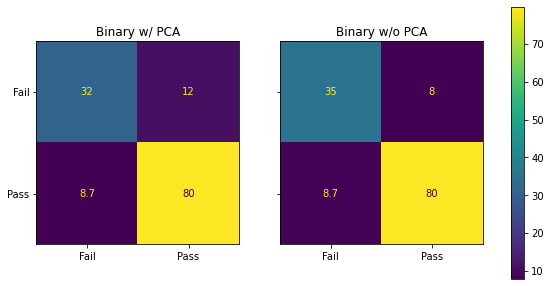

		Accuracy	Sensitivity	Precision
Binary w/ PCA	84.57%		90.15%		87.23%
Binary w/o PCA	87.34%		90.27%		90.96%


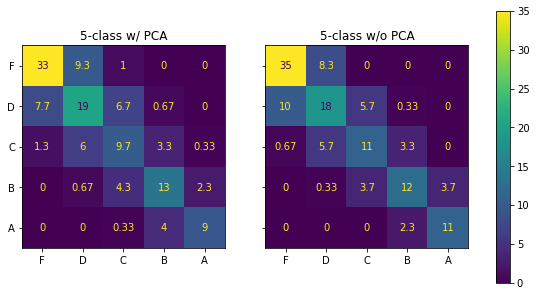

		Accuracy	Sensitivity				Precision
5-class w/ PCA	63.55%		[76.33 56.63 49.65 62.83 66.67]%	[78.84 56.49 47.22 60.06 76.8 ]%
5-class w/o PCA	66.58%		[81.17 53.44 52.65 60.98 81.25]%	[77.04 57.56 53.95 65.39 73.87]%


In [8]:
binary_label = ['Fail', 'Pass']
binary_title = ['Binary w/ PCA', 'Binary w/o PCA']
f, axes = plt.subplots(1, 2, figsize=(10, 5), sharey='row')

for i in range(0,2):
    disp = ConfusionMatrixDisplay(binary_matrics[i]/3, display_labels=binary_label)
    disp.plot(ax=axes[i])
    disp.ax_.set_title(binary_title[i])
    disp.im_.colorbar.remove()
    disp.ax_.set_xlabel('')
    disp.ax_.set_ylabel('')

f.colorbar(disp.im_, ax=axes)
plt.show()


print("\t\tAccuracy\tSensitivity\tPrecision")
for i in range(0,2):
    print(binary_title[i] + "\t" + str(round(accuracy_list[i]/3,2)) + "%\t\t" 
          + str(round(binary_recall_list[i]/3,2)) + "%\t\t" + str(round(binary_precision_list[i]/3,2)) + "%")


five_label = ['F', 'D', 'C', 'B', 'A']
five_title = ['5-class w/ PCA', '5-class w/o PCA']
f, axes = plt.subplots(1, 2, figsize=(10, 5), sharey='row')

for i in range(0,2):
    disp = ConfusionMatrixDisplay(five_matrics[i]/3, display_labels=five_label)
    disp.plot(ax=axes[i])
    disp.ax_.set_title(five_title[i])
    disp.im_.colorbar.remove()
    disp.ax_.set_xlabel('')
    disp.ax_.set_ylabel('')

f.colorbar(disp.im_, ax=axes)
plt.show()

print("\t\tAccuracy\tSensitivity\t\t\t\tPrecision")
for i in range(0,2):
    print(five_title[i] + "\t" + str(round(accuracy_list[i+2]/3,2)) + "%\t\t" 
          + str(np.round(five_recall_list[i]/3,2)) + "%\t" + str(np.round(five_precision_list[i]/3,2)) + "%")

#### Random Forest
* Use ConfusionMatrixDisplay() in scikit-learn to plot the confusion matrix of validation result for each model.
* Use plt.subplots() in matplotlib to combine all the figures as one big figure.

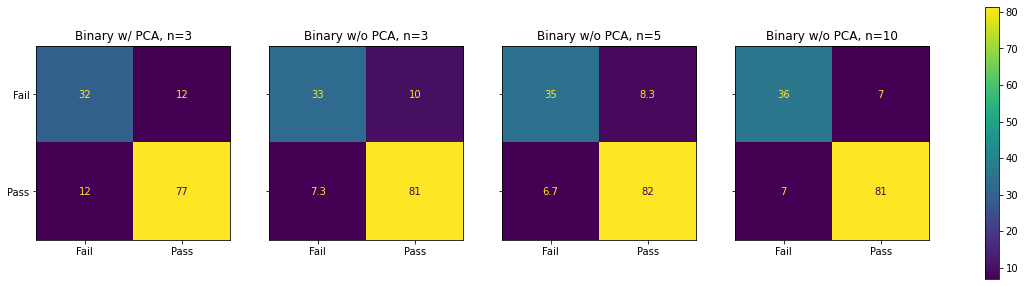

			Accuracy	Sensitivity	Precision
Binary w/ PCA, n=3	82.29%		86.79%		86.86%
Binary w/o PCA, n=3	86.58%		91.73%		88.65%
Binary w/o PCA, n=5	88.61%		92.58%		90.85%
Binary w/o PCA, n=10	89.37%		92.15%		92.05%


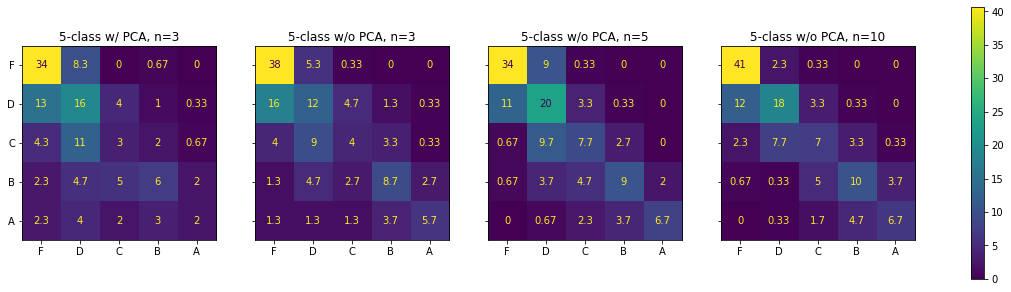

			Accuracy	Sensitivity				Precision
5-class w/ PCA, n=3	46.58%		[37.73 37.73 37.73 37.73 37.73]%	[41.62 41.62 41.62 41.62 41.62]%
5-class w/o PCA, n=3	51.41%		[45.24 45.24 45.24 45.24 45.24]%	[49.28 49.28 49.28 49.28 49.28]%
5-class w/o PCA, n=5	58.47%		[55.27 55.27 55.27 55.27 55.27]%	[60.22 60.22 60.22 60.22 60.22]%
5-class w/o PCA, n=10	63.03%		[58.34 58.34 58.34 58.34 58.34]%	[60.53 60.53 60.53 60.53 60.53]%


In [9]:
binary_label = ['Fail', 'Pass']
binary_title = ['Binary w/ PCA, n=3', 'Binary w/o PCA, n=3', 'Binary w/o PCA, n=5', 'Binary w/o PCA, n=10']
f, axes = plt.subplots(1, 4, figsize=(20, 5), sharey='row')

for i in range(0,4):
    disp = ConfusionMatrixDisplay(binary_matrics[i+2]/3, display_labels=binary_label)
    disp.plot(ax=axes[i])
    disp.ax_.set_title(binary_title[i])
    disp.im_.colorbar.remove()
    disp.ax_.set_xlabel('')
    disp.ax_.set_ylabel('')

f.colorbar(disp.im_, ax=axes)
plt.show()


print("\t\t\tAccuracy\tSensitivity\tPrecision")
for i in range(0,4):
    print(binary_title[i] + "\t" + str(round(accuracy_list[i+4]/3,2)) + "%\t\t" 
          + str(round(binary_recall_list[i+2]/3,2)) + "%\t\t" + str(round(binary_precision_list[i+2]/3,2)) + "%")


five_label = ['F', 'D', 'C', 'B', 'A']
five_title = ['5-class w/ PCA, n=3', '5-class w/o PCA, n=3', '5-class w/o PCA, n=5', '5-class w/o PCA, n=10']
f, axes = plt.subplots(1, 4, figsize=(20, 5), sharey='row')

for i in range(0,4):
    disp = ConfusionMatrixDisplay(five_matrics[i+2]/3, display_labels=five_label)
    disp.plot(ax=axes[i])
    disp.ax_.set_title(five_title[i])
    disp.im_.colorbar.remove()
    disp.ax_.set_xlabel('')
    disp.ax_.set_ylabel('')

f.colorbar(disp.im_, ax=axes)
plt.show()

print("\t\t\tAccuracy\tSensitivity\t\t\t\tPrecision")
for i in range(0,4):
    print(five_title[i] + "\t" + str(round(accuracy_list[i+8]/3,2)) + "%\t\t" 
          + str(np.round(five_recall_list[i+2]/3,2)) + "%\t" + str(np.round(five_precision_list[i+2]/3,2)) + "%")

#### K-NN
* Use ConfusionMatrixDisplay() in scikit-learn to plot the confusion matrix of validation result for each model.
* Use plt.subplots() in matplotlib to combine all the figures as one big figure.

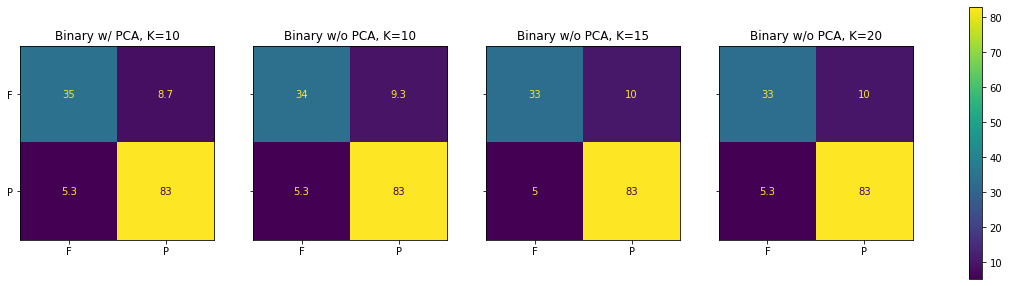

			Accuracy	Sensitivity	Precision
Binary w/ PCA, K=10	89.37%		94.09%		90.57%
Binary w/o PCA, K=10	88.86%		94.09%		89.9%
Binary w/o PCA, K=15	88.61%		94.5%		89.29%
Binary w/o PCA, K=20	88.35%		94.05%		89.23%


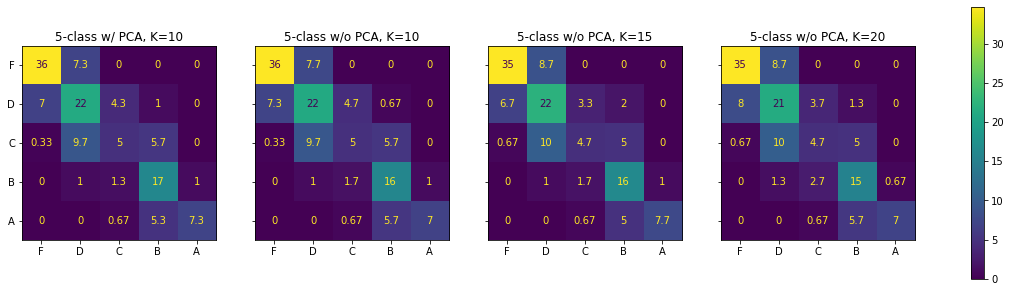

			Accuracy	Sensitivity				Precision
5-class w/ PCA, K=10	66.09%		[62.16 62.16 62.16 62.16 62.16]%	[68.67 68.67 68.67 68.67 68.67]%
5-class w/o PCA, K=10	65.07%		[61.13 61.13 61.13 61.13 61.13]%	[66.88 66.88 66.88 66.88 66.88]%
5-class w/o PCA, K=15	65.07%		[62.09 62.09 62.09 62.09 62.09]%	[69.17 69.17 69.17 69.17 69.17]%
5-class w/o PCA, K=20	63.04%		[59.92 59.92 59.92 59.92 59.92]%	[65.08 65.08 65.08 65.08 65.08]%


In [10]:
binary_label = ['F', 'P']
binary_title = ['Binary w/ PCA, K=10', 'Binary w/o PCA, K=10', 'Binary w/o PCA, K=15', 'Binary w/o PCA, K=20']
f, axes = plt.subplots(1, 4, figsize=(20, 5), sharey='row')

for i in range(0,4):
    disp = ConfusionMatrixDisplay(binary_matrics[i+6]/3, display_labels=binary_label)
    disp.plot(ax=axes[i])
    disp.ax_.set_title(binary_title[i])
    disp.im_.colorbar.remove()
    disp.ax_.set_xlabel('')
    disp.ax_.set_ylabel('')

f.colorbar(disp.im_, ax=axes)
plt.show()


print("\t\t\tAccuracy\tSensitivity\tPrecision")
for i in range(0,4):
    print(binary_title[i] + "\t" + str(round(accuracy_list[i+12]/3,2)) + "%\t\t" 
          + str(round(binary_recall_list[i+6]/3,2)) + "%\t\t" + str(round(binary_precision_list[i+6]/3,2)) + "%")


five_label = ['F', 'D', 'C', 'B', 'A']
five_title = ['5-class w/ PCA, K=10', '5-class w/o PCA, K=10', '5-class w/o PCA, K=15', '5-class w/o PCA, K=20']
f, axes = plt.subplots(1, 4, figsize=(20, 5), sharey='row')

for i in range(0,4):
    disp = ConfusionMatrixDisplay(five_matrics[i+6]/3, display_labels=five_label)
    disp.plot(ax=axes[i])
    disp.ax_.set_title(five_title[i])
    disp.im_.colorbar.remove()
    disp.ax_.set_xlabel('')
    disp.ax_.set_ylabel('')

f.colorbar(disp.im_, ax=axes)
plt.show()

print("\t\t\tAccuracy\tSensitivity\t\t\t\tPrecision")
for i in range(0,4):
    print(five_title[i] + "\t" + str(round(accuracy_list[i+16]/3,2)) + "%\t\t" 
          + str(np.round(five_recall_list[i+6]/3,2)) + "%\t" + str(np.round(five_precision_list[i+6]/3,2)) + "%")

## 7. Comparison & Conclusion

* PCA or not
    * 由decision tree以及random forest可以觀察到，將前處理過後的資料做PCA，有時候會導致model performance些微下降。
    * KNN有沒有做PCA的performance差異不大，但有做PCA可能會稍微提高performance，且因為訓練時的dimension較低，可以讓效率變佳。
    * 以上這種狀況發生的因素可能是因為PCA後的資料之維度並不代表特定feature，而是多個feature組合而成的新的座標系，故可以推測PCA較適合用在KNN，而非decision tree以及random forest。


* Binary or 5-Level classification
    * 由以上三種模型可以觀察到，只要將target的種類變多，model的performance也會因此下降，推測是因為每個種類的判斷範圍變小，增加錯誤機率。


* Different number of tree for Random Forest
    * 從以上實驗可以觀察到當樹的數量越多，performance會越佳，推測是因為在投票時每棵樹在整體得票所佔之比例降低，少數預測錯誤並不會造成整體預測錯誤，進而使得容錯率變高。
    
* Different value of K for K-NN
    * 在K值不同的情況下，performance會在K=10-15時達到最高值，不過所有K值的表現相差不大，推測是因為有使用weight，可以有效降低雜訊的影響。


* Normalized or not
    * 目前作業呈現的都是numerical features未經過normalize的結果。
    * 一開始numerical feature先做了normalize，但發現performance並不理想，尤其是KNN在binary classification下的表現更是不超過70%。
    * 若是使用numerical featured normalized的資料畫第八部分的scatter plot的話，會讓每個點都均勻散佈，這也就是為什麼KNN表現不佳的原因。

## 8. Questions

#### Decision Tree
##### Show the prediction and reasoning of one arbitrary sample in the testing set. - 10%

Prediction: f
Ground Truth: f


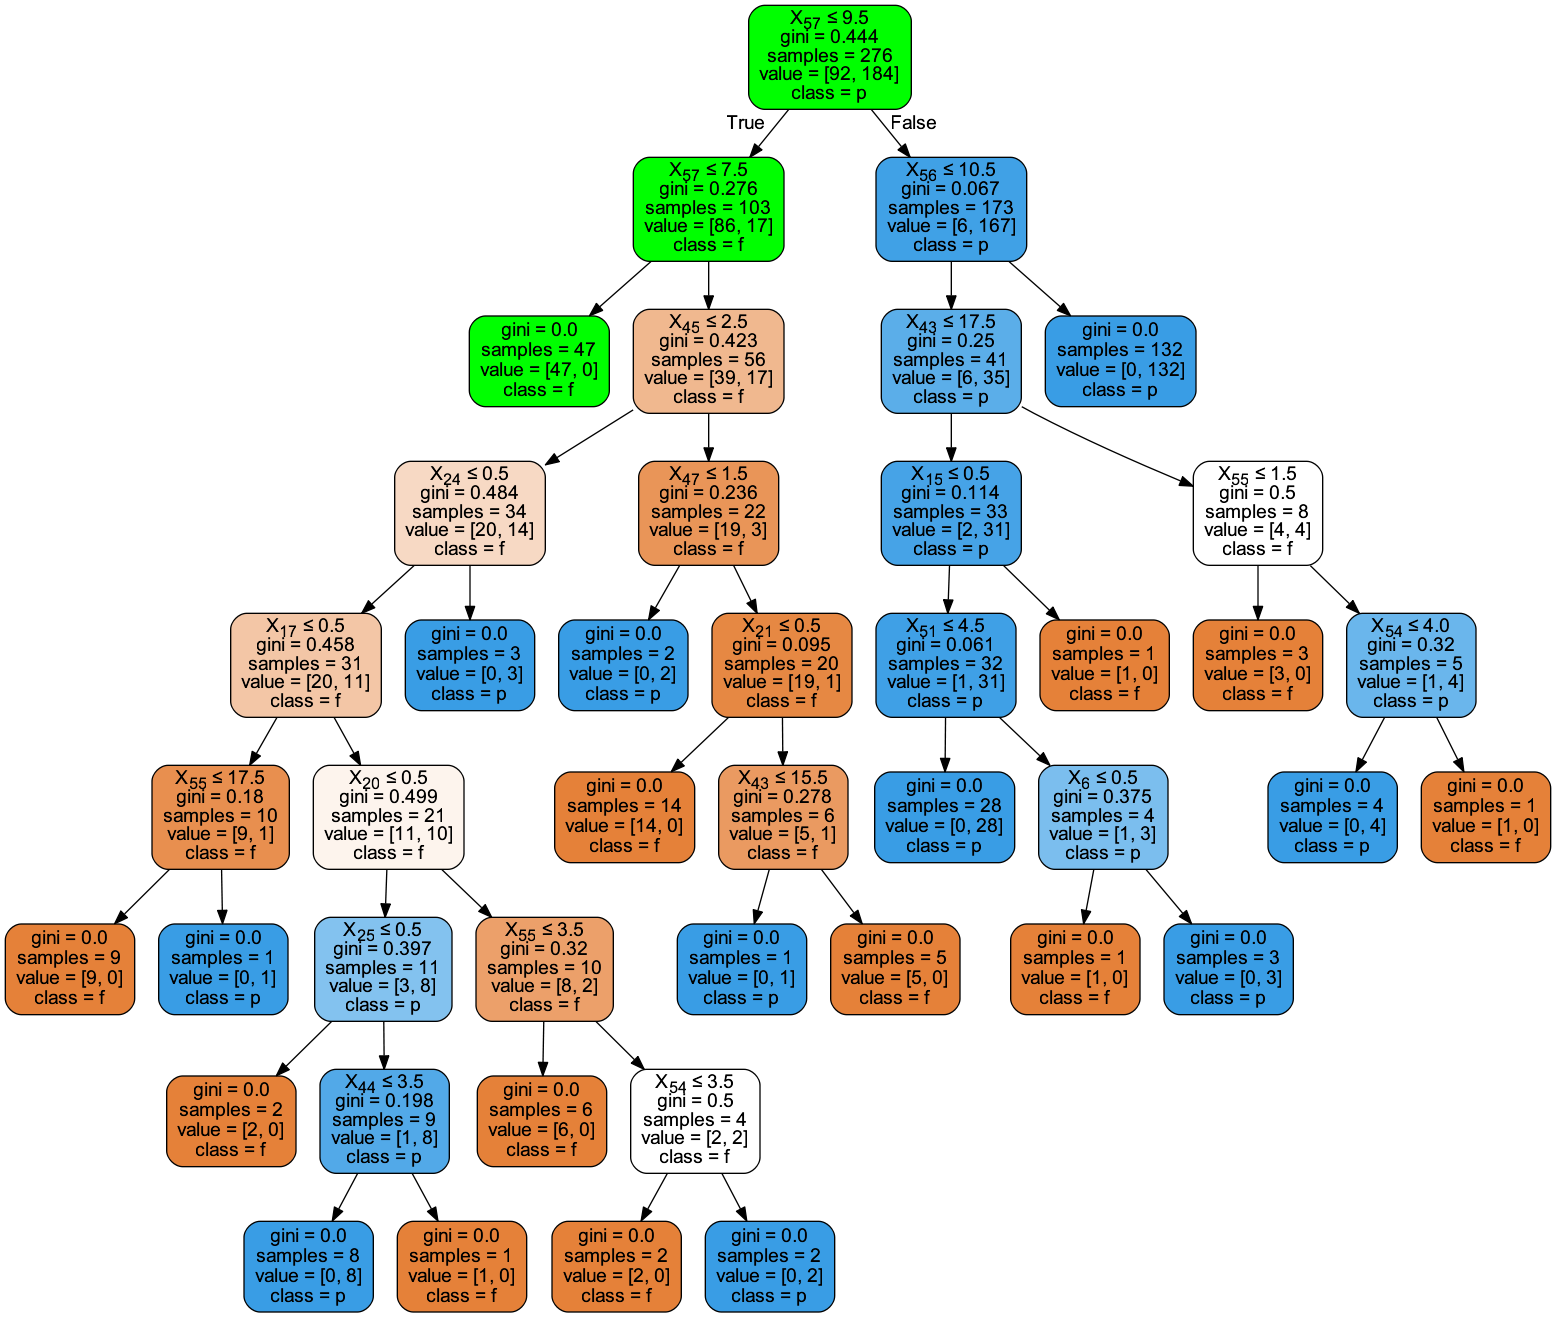

In [11]:
from IPython.display import Image
class_label = ['f', 'p']

# build decision tree model with holdout validation
question_tree = DecisionTreeClassifier()
x_train, x_test, y_train, y_test = train_test_split(X,binary_Y,test_size=0.3)
question_tree.fit(x_train, y_train)

# get dot format of trained tree and use pydotplus.graph_from_dot_data() to generate the figure
dot_data = export_graphviz(question_tree, out_file=None, filled=True, rounded=True, special_characters=True, class_names=class_label)
graph = pydotplus.graph_from_dot_data(dot_data)

# randomly select one sample from the test data split
index = choice(range(0,len(x_test)))
sample = x_test[index:index+1]

# get the prediction and the decision path of the selected sample
prediction = question_tree.predict(sample)
decision_path = question_tree.decision_path(sample)[0]
print(f'Prediction: {class_label[int(prediction[0])]}')
print(f'Ground Truth: {class_label[int(y_test[index:index+1][0])]}')

# find the decision path on the tree plot and fill the nodes on the path with green
decision_path = decision_path.toarray()[0]
for i in range(0,len(decision_path)):
    if decision_path[i] == 1:
        node = graph.get_node(str(i))[0]            
        node.set_fillcolor('green')

# generate the plot by using Image() in IPython.display
Image(graph.create_png())

#### Random Forest
##### Describe the difference between boosting and bagging. - 5%

* Bagging在建立每棵decision tree的時候都是獨立建立，也就是說每棵樹都是獨立的存在，訓練選取之資料以及最終投票皆不會有權重的影響。
* Boosting在建立每棵decision tree時為依序建立，也就是說第n棵建立完後才會開始建立第n+1棵，此外較新的樹也會參考過去的訓練結果，對訓練資料的選取會有權重的不同，通常會著重在validation時分類錯誤的sample並增加其權重，也因為越後面的樹會有更充足的過往經驗，故在預測投票時的權重也會有所不同。
    * 值得注意的是，某些雜訊會因為持續被選取用來訓練模型而大大影響了boosting的訓練結果，也就是說對於雜訊十分敏感，最後可能會使得模型performance不如預期。
    * 因為會根據過往經驗而重複訓練多次而造成over-fitting的問題，同樣也會造成效能以及表現有所下降。

#### KNN
##### Show the prediction and reasoning of one arbitrary sample in the testing set. - 10%

In [12]:
class_label = ['f', 'p']

# build K-NN model with holdout validation and K=3
knn = KNeighborsClassifier(n_neighbors=3)
x_train, x_test, y_train, y_test = train_test_split(X,binary_Y,test_size=0.3)
knn.fit(x_train, y_train)

# randomly select one sample from the test data split
index = choice(range(0,len(x_test)))
sample = x_test[index:index+1]
prediction = knn.predict(sample)

# find the nearest K=3 neighbors
dist, ind = knn.kneighbors(sample)
dist = dist[0]
ind = ind[0]

# print the distance and label of the nearest neighbors
for i in range(0,len(ind)):
    print(f'Index in training data: {ind[i]}')
    print(f'Distance: {dist[i]}')
    print(f'Label: {class_label[int(y_train[ind[i]])]}')
    print()

print(f'Prediction: {class_label[int(prediction)]}')
print(f'Ground truth: {class_label[int(y_test[index])]}')

Index in training data: 162
Distance: 20.322401432901575
Label: f

Index in training data: 185
Distance: 22.20360331117452
Label: p

Index in training data: 156
Distance: 37.61648574760805
Label: f

Prediction: f
Ground truth: f


##### Bonus: pick 2 features, draw and describe the KNN decision boundaries. - 10%
* You can pick 2 features to re-train the model, or just fix every other feature value.

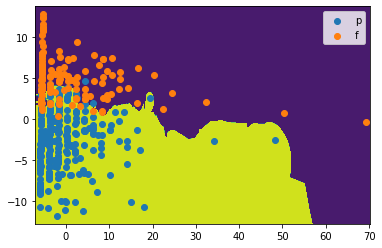

In [13]:
###### This part refer to document of scikit-learn https://scikit-learn.org/stable/auto_examples/neighbors/plot_classification.html ######
# PCA
pca_question = PCA(n_components=2)
pca_question.fit(X)
X_pca_question = pca_question.transform(X)

# find the range of x0 and x1, then generate equal width interval
x0 = np.arange(X_pca_question[:,0].min()-1, X_pca_question[:,0].max()+1, 0.05)
x1 = np.arange(X_pca_question[:,1].min()-1, X_pca_question[:,1].max()+1, 0.05)

# generate meshgrid to be the input of prediction
x0, x1 = np.meshgrid(x0, x1)

# build k-nn model with k=15
knn = KNeighborsClassifier(n_neighbors=15, weights="distance")
knn.fit(X_pca_question, binary_Y)

# find the value of each point of the meshgrid
y = knn.predict(np.c_[x0.reshape(-1), x1.reshape(-1)])

# reshape the output as x0 and plot the decision boundary with x0, x1, y
y = y.reshape(x0.shape)
plt.contourf(x0, x1, y)

# show the scatter plot of training data
binary_label = ['f','p']
binary_Y_np = np.array(binary_Y)

for i in range(0,2):
    index = np.where(binary_Y_np == 1-i)
    plt.scatter(X_pca_question[index,0], X_pca_question[index,1], label=binary_label[1-i])
plt.legend()

plt.show()

#### PCA
##### In 5-Level classification, reduce the data dimension to 2 using PCA and draw a scatter plot. You have to colorize the data points based on their labels. - 10%

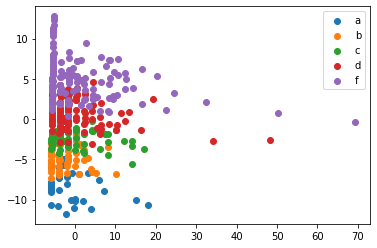

In [14]:
# PCA
pca_question = PCA(n_components=2)
pca_question.fit(X)
X_pca_question = pca_question.transform(X)

# show the scatter plot of training data
five_label = ['f','d','c','b','a']
five_Y_np = np.array(five_Y)

for i in range(0,5):
    index = np.where(five_Y_np == (4-i))
    plt.scatter(X_pca_question[index,0], X_pca_question[index,1], label=five_label[4-i])
plt.legend()
plt.show()